## In-Vehicle Coupon Recommendation System
## Author:Fathima Yasmin
## Date: August 2025 



## Phase 1:Importing Libraries and Dataset

In [3]:
!pip install optuna


In [4]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
import zipfile
import requests
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [5]:
# Download and extract the ZIP file
url = "https://archive.ics.uci.edu/static/public/603/in+vehicle+coupon+recommendation.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df = pd.read_csv(f)
df.head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## Basic Checks

In [7]:
# Dataset shape
print(f"Total number of rows in the dataset: {df.shape[0]} ")
print(f"Total number of columns in the dataset: {df.shape[1]} ")
df.shape

Total number of rows in the dataset: 12684 
Total number of columns in the dataset: 26 


(12684, 26)

In [8]:
# Print all column names
print("Column Names:")
print(df.columns.tolist())


Column Names:
['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']


In [9]:
# Datatype infomations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [10]:
# to show the data frame
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [11]:
#summary statistics of numeric columns in the DataFrame.
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


## Phase 2: Data Cleaning

In [13]:
#check for dublicate values
df.duplicated().sum()

74

In [14]:
#removing dublicate values
df.drop_duplicates(inplace=True)

In [15]:
#verify dublicates are removed
print("Remaining duplicates:", df.duplicated().sum())
print("Shape after removing duplicates:", df.shape)

#Reset index after dropping 
df.reset_index(drop=True, inplace=True)

Remaining duplicates: 0
Shape after removing duplicates: (12610, 26)


In [16]:
# HANDLING MISSING VALUES
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12502
Bar                       107
CoffeeHouse               217
CarryAway                 150
RestaurantLessThan20      129
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64


In [17]:
# Drop the 'car' column (too many missing values)
df.drop(columns = ['car'], errors='ignore', inplace=True)

# Fill missing values in food/restaurant visit frequency columns with 'never'
fill_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
df[fill_cols] = df[fill_cols].fillna('never')

#4 # Confirm cleanup
print("Remaining missing values:\n", df.isnull().sum())
print("Shape after treating missing values:", df.shape)

Remaining missing values:
 destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64
Shape after treating missing values: (12610, 25)


In [18]:
#unique values in each column
df.nunique()

destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
direction_opp            2
Y                        2
dtype: int64

## Phase 3: Feature Categorization 

In [20]:
#COLUMN CATEGORIZATION

#TAGET COLUMN
target_col = 'Y'

#CATEGORICAL COLUMNS
categorical_cols = [
    'destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
    'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
    'Restaurant20To50', 'direction_same', 'direction_opp'
]

#NUMERICAL COLUMNS
numerical_cols = [
    'temperature', 'has_children',
    'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'
]

# Convert all object-type columns to 'category'
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Converted the following columns to 'category':")
print((categorical_cols.tolist()))

print("Target Column:", target_col)
print("Numerical Columns:\n", numerical_cols)

Converted the following columns to 'category':
['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
Target Column: Y
Numerical Columns:
 ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']


In [21]:
# Final summary
print("Final dataset info:")
print(df.info())

# Show sample data
df.head()

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12610 entries, 0 to 12609
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12610 non-null  category
 1   passanger             12610 non-null  category
 2   weather               12610 non-null  category
 3   temperature           12610 non-null  int64   
 4   time                  12610 non-null  category
 5   coupon                12610 non-null  category
 6   expiration            12610 non-null  category
 7   gender                12610 non-null  category
 8   age                   12610 non-null  category
 9   maritalStatus         12610 non-null  category
 10  has_children          12610 non-null  int64   
 11  education             12610 non-null  category
 12  occupation            12610 non-null  category
 13  income                12610 non-null  category
 14  Bar                   12610 non-nu

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,4~8,1~3,1,1,0,0,1,0


In [22]:
# Separate features and target
X = df.drop('Y', axis=1)
y = df['Y' ]

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
X_train

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
2874,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,36,Married partner,...,never,1~3,4~8,1~3,1~3,1,1,0,0,1
11079,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,41,Married partner,...,less1,4~8,gt8,1~3,less1,1,1,0,0,1
11789,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Unmarried partner,...,less1,never,1~3,never,never,1,0,0,0,1
8869,Home,Kid(s),Sunny,80,6PM,Restaurant(20-50),2h,Female,31,Married partner,...,never,4~8,4~8,less1,less1,1,1,0,1,0
3058,No Urgent Place,Kid(s),Sunny,80,2PM,Restaurant(<20),1d,Female,41,Married partner,...,less1,gt8,4~8,gt8,less1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,21,Single,...,1~3,less1,less1,less1,less1,1,0,0,1,0
5191,Work,Alone,Sunny,80,7AM,Carry out & Take away,1d,Female,50plus,Unmarried partner,...,never,never,4~8,1~3,less1,1,1,1,0,1
5390,Work,Alone,Sunny,80,7AM,Carry out & Take away,1d,Female,26,Unmarried partner,...,1~3,1~3,1~3,1~3,1~3,1,0,0,1,0
860,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,26,Unmarried partner,...,never,1~3,1~3,1~3,less1,1,1,0,0,1


In [24]:
y_train

2874     0
11079    0
11789    0
8869     1
3058     1
        ..
11964    0
5191     1
5390     1
860      1
7270     1
Name: Y, Length: 10088, dtype: int64

## Phase 4: Exploratory Data Analysis (EDA)

In [26]:
 # Value counts of important categorical features
categorical_to_plot = ['coupon', 'weather', 'gender', 'age', 'income', 'education']

for col in categorical_to_plot:
    print(f"\\nValue counts for {col}:")
    print(df[col].value_counts())
    print("-" * 40)# Value counts of important categorical features


\nValue counts for coupon:
coupon
Coffee House             3989
Restaurant(<20)          2779
Carry out & Take away    2344
Bar                      2010
Restaurant(20-50)        1488
Name: count, dtype: int64
----------------------------------------
\nValue counts for weather:
weather
Sunny    10011
Snowy     1397
Rainy     1202
Name: count, dtype: int64
----------------------------------------
\nValue counts for gender:
gender
Female    6469
Male      6141
Name: count, dtype: int64
----------------------------------------
\nValue counts for age:
age
21         2642
26         2548
31         2019
50plus     1781
36         1317
41         1089
46          670
below21     544
Name: count, dtype: int64
----------------------------------------
\nValue counts for income:
income
$25000 - $37499     2006
$12500 - $24999     1825
$37500 - $49999     1795
$100000 or More     1717
$50000 - $62499     1655
Less than $12500    1034
$87500 - $99999      879
$75000 - $87499      856
$62500 - $749

In [27]:
# Remove target from lists if present
if target_col in numerical_cols:
    numrical_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

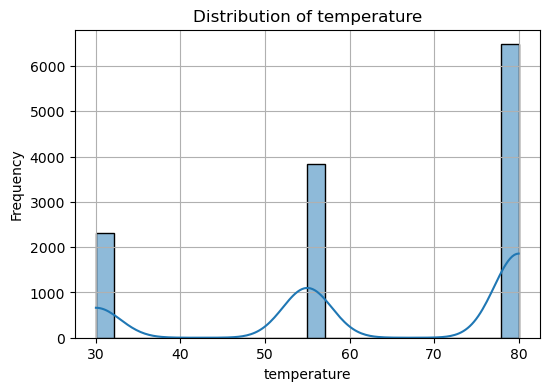

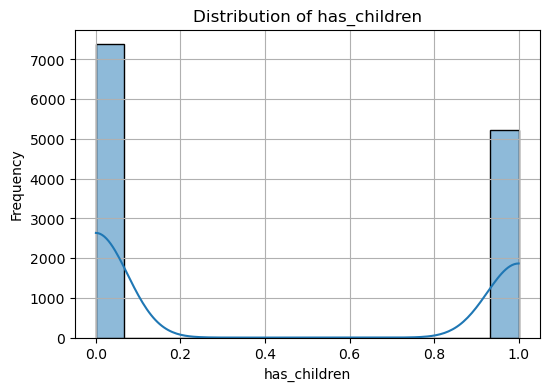

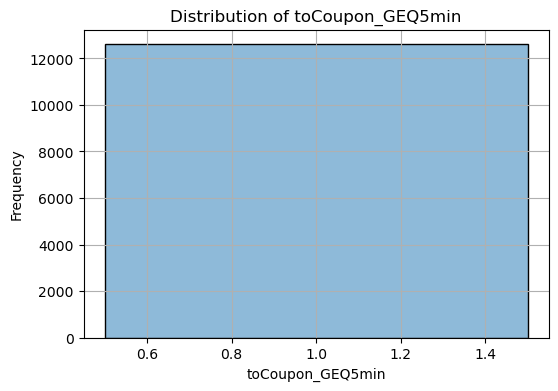

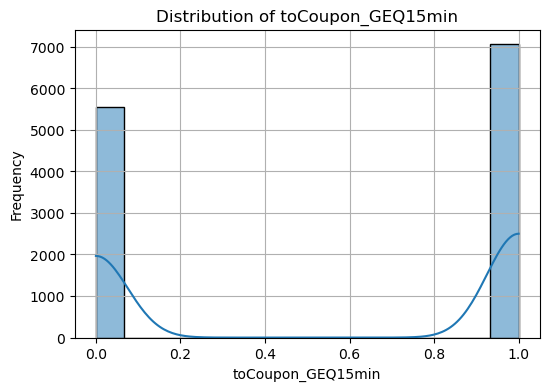

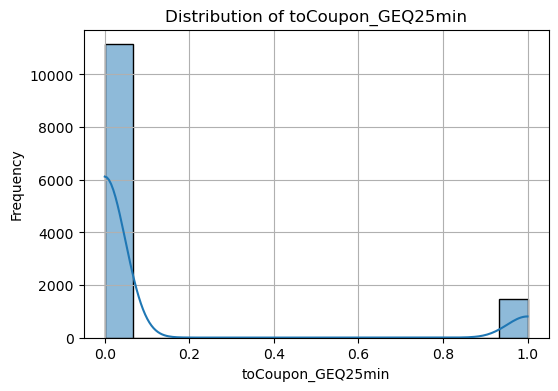

In [28]:
#Distribution Plots for Numerical Columns

# Histograms of numerical columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

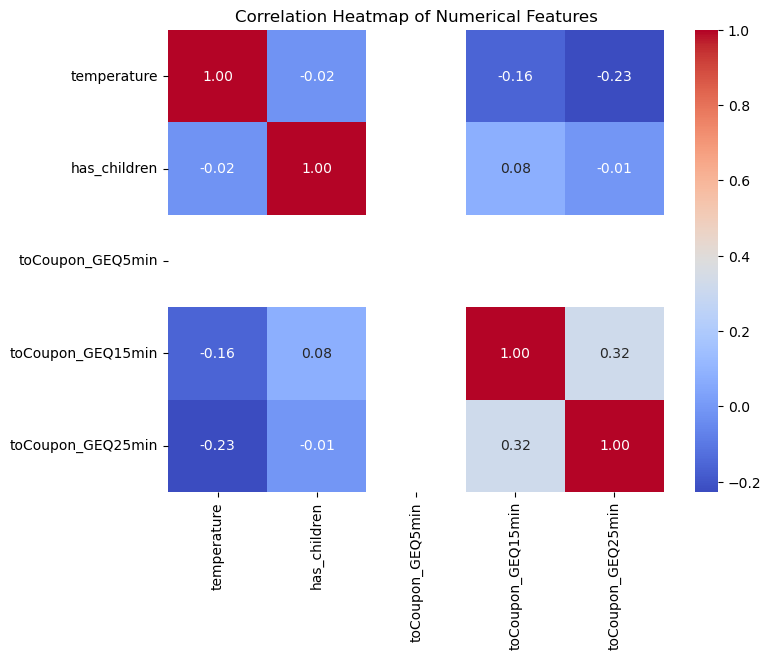

In [29]:
#Correlation Matrix (Numerical Features)

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

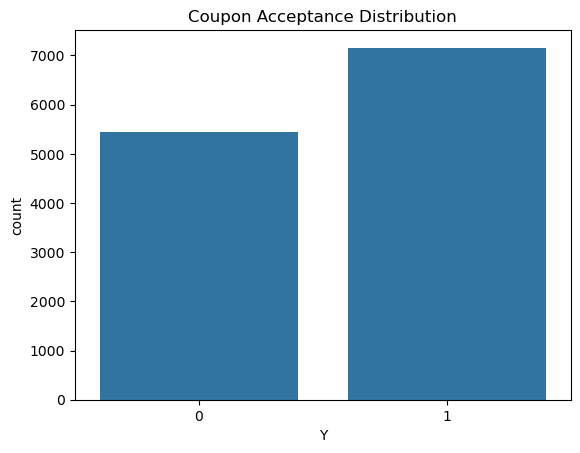

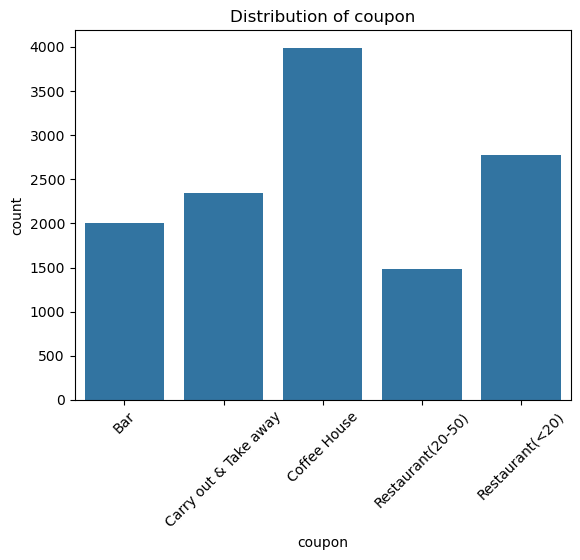

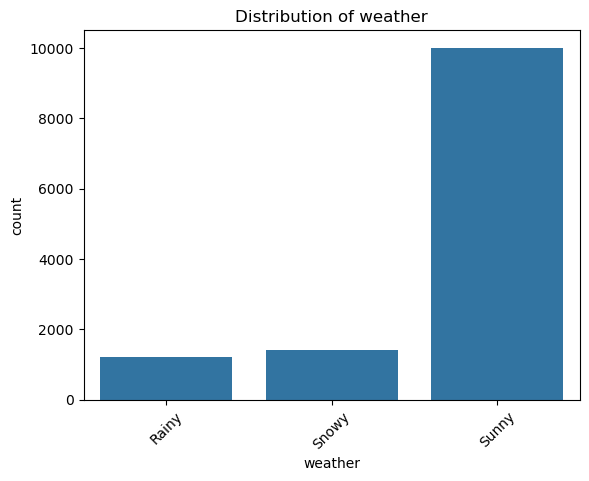

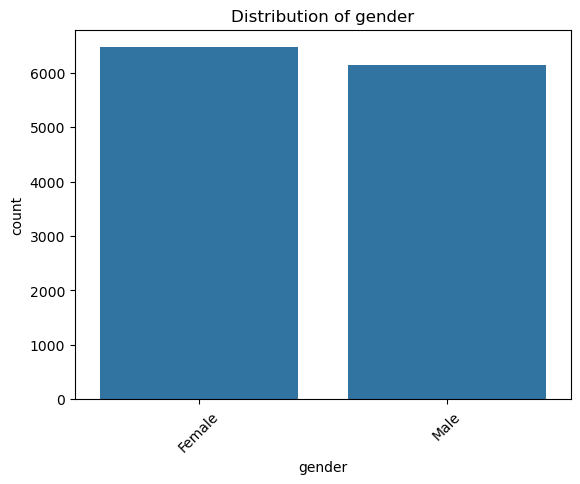

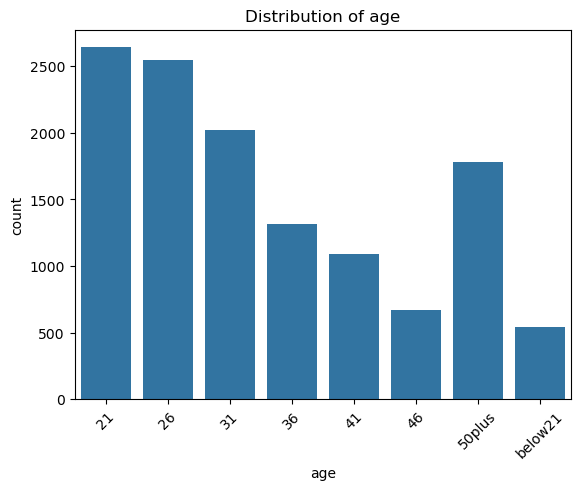

In [30]:
 #Plot distribution of target
sns.countplot(x='Y', data=df)
plt.title('Coupon Acceptance Distribution')
plt.show()

# Bar plots for some categorical features
for col in ['coupon', 'weather', 'gender', 'age']:
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

## Data Aggregation and Trend Plot

Groups the DataFrame df by the Time column and counts how many records exist for each day.

Creates a line plot with:

X-axis: Time

Y-axis: Number of records per day

Blue line with circular markers to show daily counts

Adds labels, a title, and a grid for better readability.

C:\Users\user\AppData\Local\Temp\ipykernel_3364\817993653.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_counts = df.groupby('time').size().reset_index(name='count')


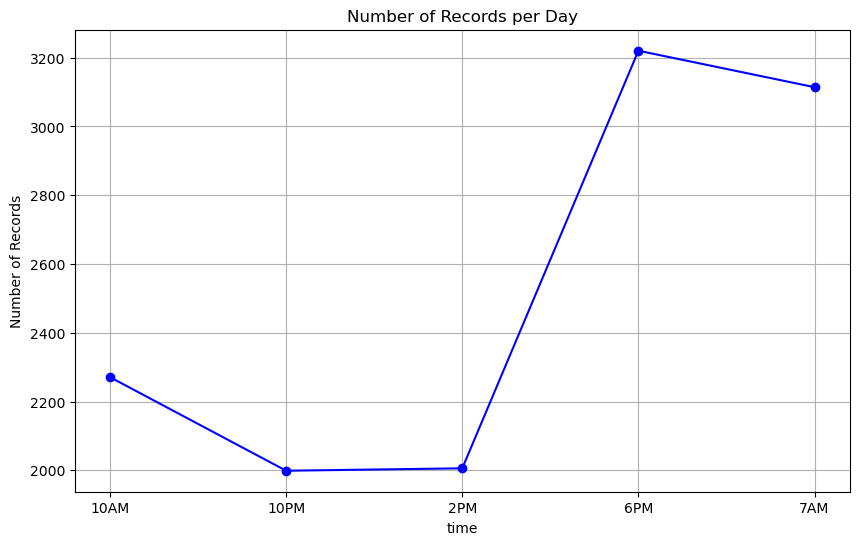

In [32]:
# Group by time and count the number of records for each day
daily_counts = df.groupby('time').size().reset_index(name='count')
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_counts['time'], daily_counts['count'], marker='o', linestyle='-', color='b')
plt.title('Number of Records per Day')
plt.xlabel('time')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

The Plot Tells:

-Troughs show days with fewer records.

-If the line is relatively flat, your data is evenly distributed across time.

-If there are sudden spikes or drops, those might be worth investigating

## Skewness Handling

In [35]:
from scipy.stats import skew

#Check original skewness
skewness = df[numerical_cols].skew()
print("Original skewness:\n", skewness)


Original skewness:
 temperature         -0.640000
has_children         0.347102
toCoupon_GEQ5min     0.000000
toCoupon_GEQ15min   -0.240933
toCoupon_GEQ25min    2.398310
dtype: float64


The temperature column is highly skewed

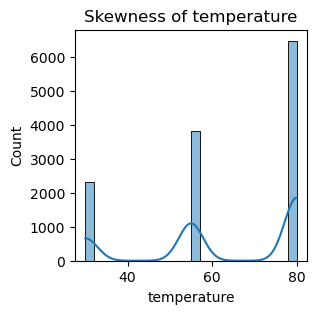

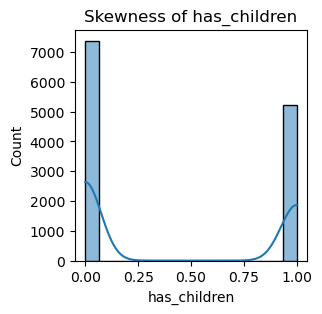

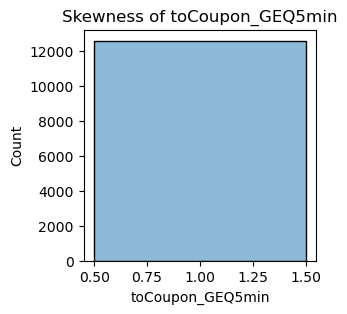

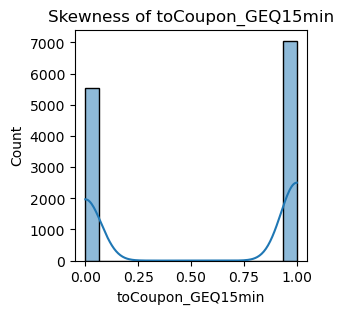

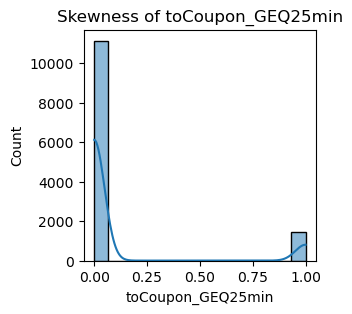

In [37]:
# check skewness visually
for col in numerical_cols:
    plt.figure(figsize=(3, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Skewness of {col}')
    plt.show()

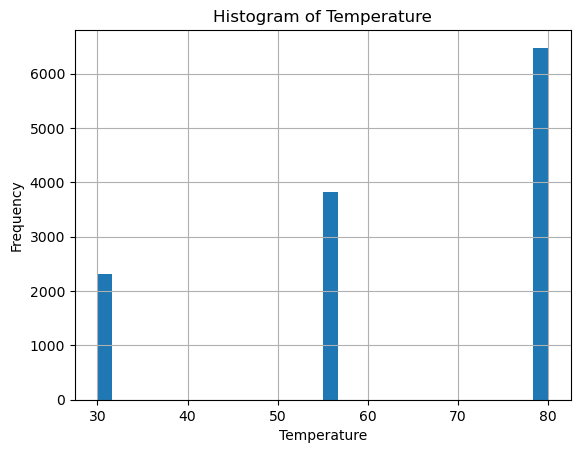

In [38]:
# Treating Skewness
df['temperature'].hist(bins=30)
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [39]:
df['temperature_squared'] = df['temperature']**2
print("Temperatured Squared Skew:",df['temperature_squared'].skew())


Temperatured Squared Skew: -0.37959437225408377


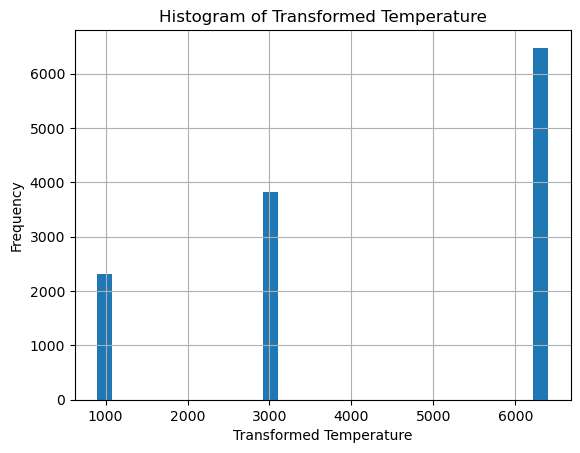

In [40]:
# visualization of Tansformed Tempeature
df['temperature_squared'].hist(bins=30)
plt.title('Histogram of Transformed Temperature')
plt.xlabel('Transformed Temperature')
plt.ylabel('Frequency')
plt.show()

In [41]:
df[numerical_cols].skew()

temperature         -0.640000
has_children         0.347102
toCoupon_GEQ5min     0.000000
toCoupon_GEQ15min   -0.240933
toCoupon_GEQ25min    2.398310
dtype: float64

In [42]:
from scipy.stats import boxcox, yeojohnson

# Apply transformation
for col in numerical_cols:
    if abs(df[col].skew()) > 0.5:  # threshold for skewness
        if (df[col] <= 0).any():
            # Yeo-Johnson works with zero or negative values
            df[col], _ = yeojohnson(df[col])
            print(f"Applied Yeo-Johnson transformation on: {col}")
        else:
            # Box-Cox works only with positive values
            df[col], _ = boxcox(df[col])
            print(f"Applied Box-Cox transformation on: {col}")


Applied Box-Cox transformation on: temperature
Applied Yeo-Johnson transformation on: toCoupon_GEQ25min


In [43]:
# Re-check the transformed temperature is applied
df[numerical_cols].skew()

temperature         -0.389377
has_children         0.347102
toCoupon_GEQ5min     0.000000
toCoupon_GEQ15min   -0.240933
toCoupon_GEQ25min    2.398310
dtype: float64

## Boxplot showing range and outliers for each numerical column

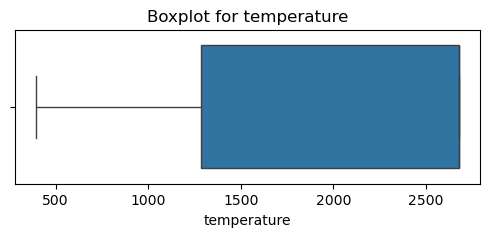

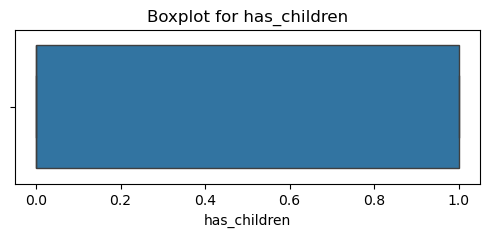

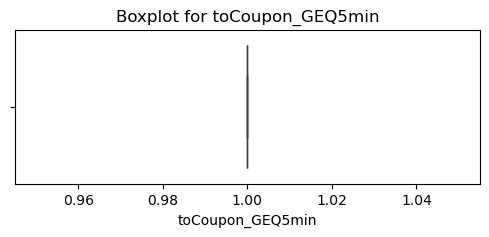

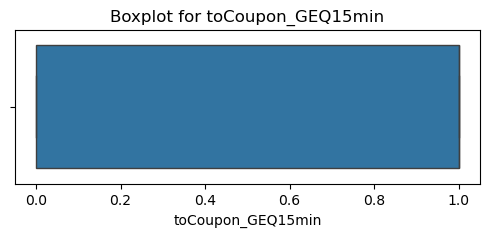

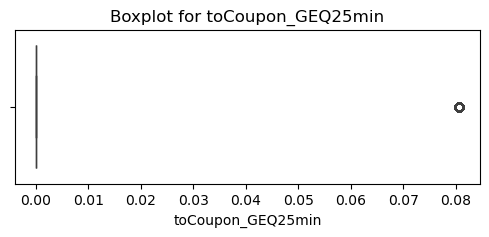

In [45]:
for i in numerical_cols:
  plt.figure(figsize=(6,2))
  sns.boxplot(data = df, x = i)
  plt.title('Boxplot for {}'.format(i))


In [46]:
# Detect Outliers Using IQR Method
outlier_indices = {}

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    if not outliers.empty:
        outlier_indices[col] = outliers.index.tolist()

outlier_indices


{'toCoupon_GEQ25min': [16,
  17,
  38,
  39,
  60,
  61,
  82,
  83,
  104,
  105,
  126,
  127,
  148,
  149,
  170,
  171,
  189,
  209,
  210,
  231,
  232,
  253,
  254,
  275,
  276,
  295,
  296,
  317,
  318,
  337,
  338,
  359,
  360,
  381,
  382,
  403,
  404,
  425,
  426,
  446,
  447,
  468,
  489,
  490,
  511,
  512,
  539,
  540,
  561,
  562,
  583,
  584,
  605,
  606,
  627,
  628,
  649,
  650,
  671,
  672,
  693,
  694,
  715,
  716,
  737,
  738,
  759,
  760,
  781,
  782,
  803,
  804,
  824,
  825,
  846,
  847,
  874,
  875,
  896,
  897,
  918,
  919,
  940,
  941,
  962,
  963,
  984,
  985,
  1006,
  1007,
  1028,
  1029,
  1050,
  1051,
  1072,
  1073,
  1094,
  1095,
  1116,
  1117,
  1138,
  1139,
  1160,
  1161,
  1188,
  1189,
  1209,
  1210,
  1231,
  1232,
  1253,
  1254,
  1275,
  1276,
  1297,
  1298,
  1319,
  1320,
  1341,
  1342,
  1363,
  1364,
  1385,
  1386,
  1407,
  1408,
  1429,
  1430,
  1451,
  1452,
  1473,
  1474,
  1495,
  1496,
  1

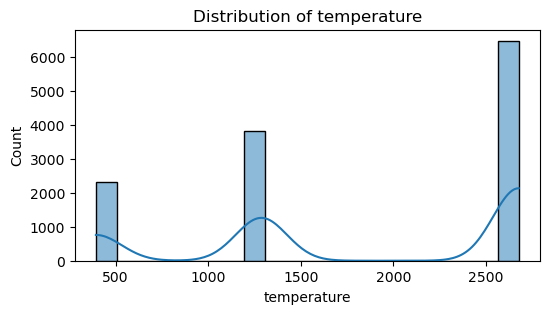

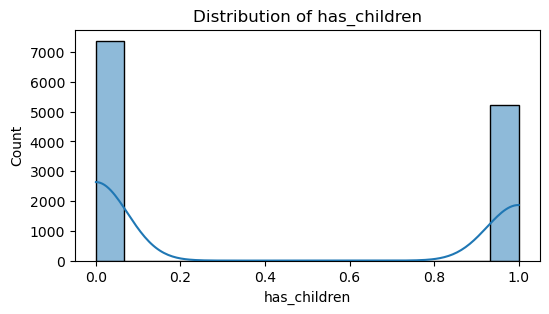

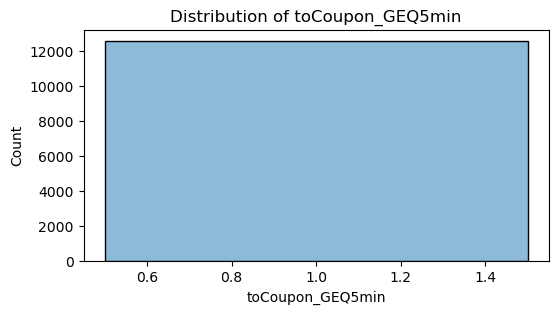

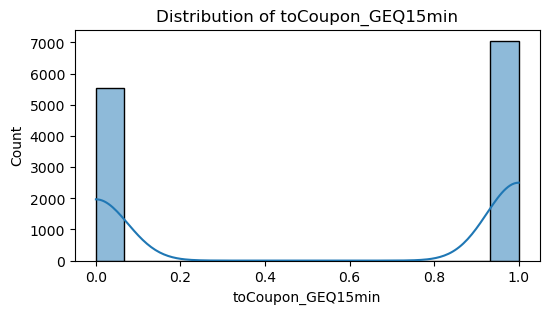

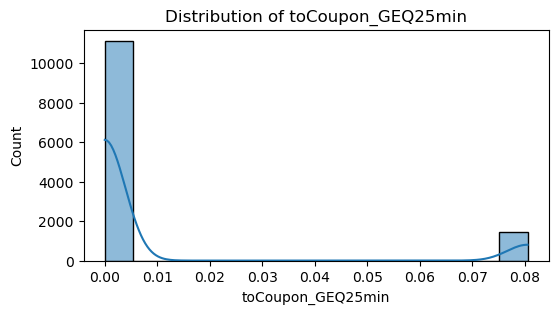

In [47]:
#Histogram with KDE Curve (for distribution & outliers)
for col in numerical_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [48]:
#TREATING OUTLIER USING CAPPING ((Winsorization)

for col in outlier_indices:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    print(" Outliers capped successfully.")

 Outliers capped successfully.


In [49]:
# Verify Changes
df[numerical_cols].describe()


,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min
count,12610.000000,12610.000000,12610.0,12610.000000,12610.0
mean,1837.191006,0.414512,1.0,0.559794,0.0
std,913.771522,0.492657,0.0,0.496432,0.0
min,393.351422,0.000000,1.0,0.000000,0.0
25%,1286.889479,0.000000,1.0,0.000000,0.0
50%,2676.682139,0.000000,1.0,1.000000,0.0
75%,2676.682139,1.000000,1.0,1.000000,0.0
max,2676.682139,1.000000,1.0,1.000000,0.0


Visualizing Outlier Treatment Before v/s After

In [51]:
#Create a copy of the original DataFrame before capping
df_before_capping = df.copy()

Applied capping to column: temperature_squared

After capping:
            destination  passanger weather  temperature  time  \
0      No Urgent Place      Alone   Sunny  1286.889479   2PM   
1      No Urgent Place  Friend(s)   Sunny  2676.682139  10AM   
2      No Urgent Place  Friend(s)   Sunny  2676.682139  10AM   
3      No Urgent Place  Friend(s)   Sunny  2676.682139   2PM   
4      No Urgent Place  Friend(s)   Sunny  2676.682139   2PM   
...                ...        ...     ...          ...   ...   
12605             Home    Partner   Rainy  1286.889479   6PM   
12606             Work      Alone   Rainy  1286.889479   7AM   
12607             Work      Alone   Snowy   393.351422   7AM   
12608             Work      Alone   Snowy   393.351422   7AM   
12609             Work      Alone   Sunny  2676.682139   7AM   

                      coupon expiration  gender age      maritalStatus  ...  \
0            Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1        

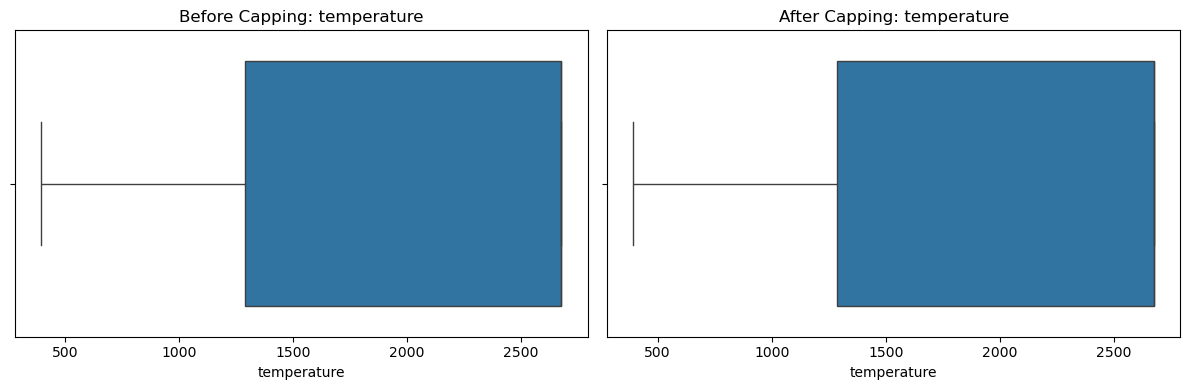

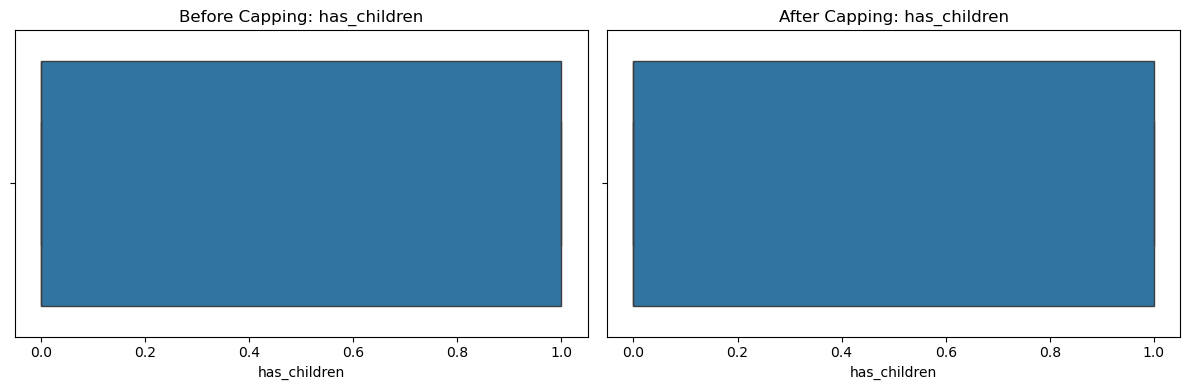

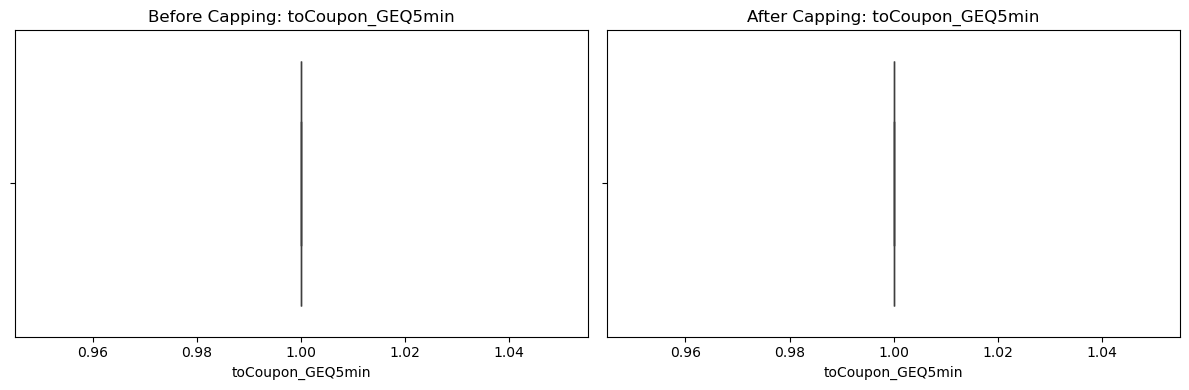

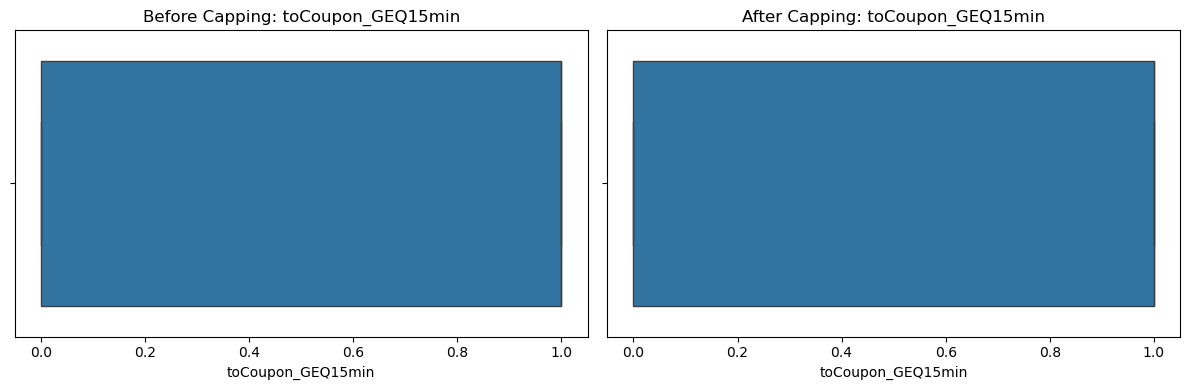

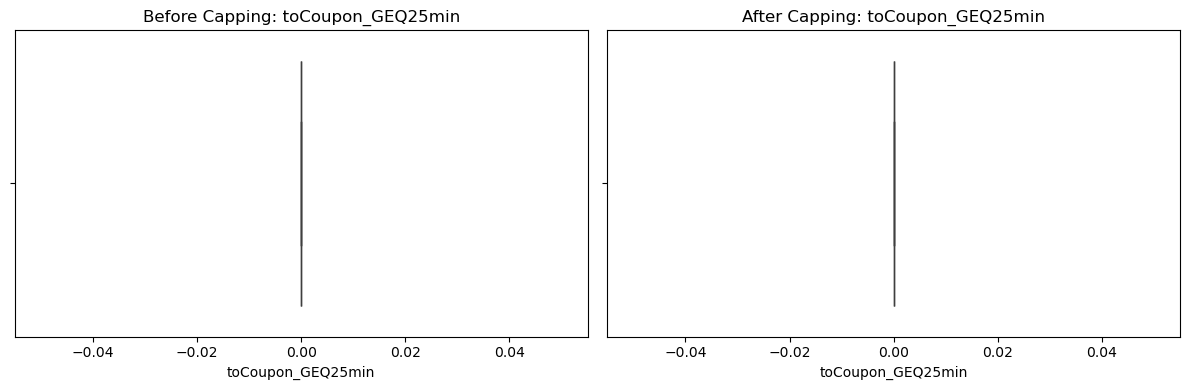

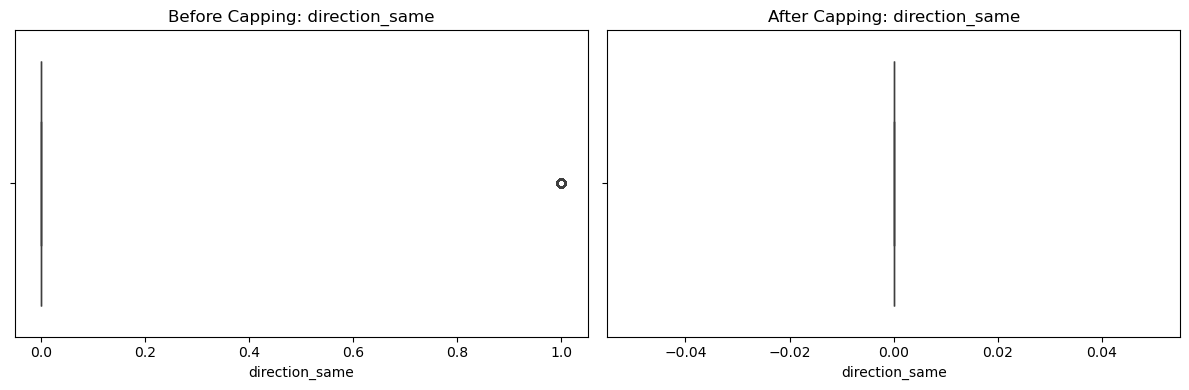

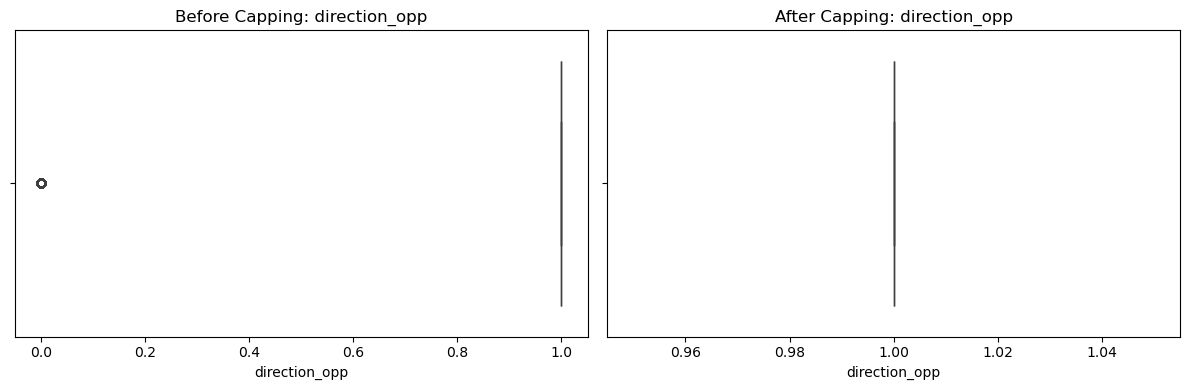

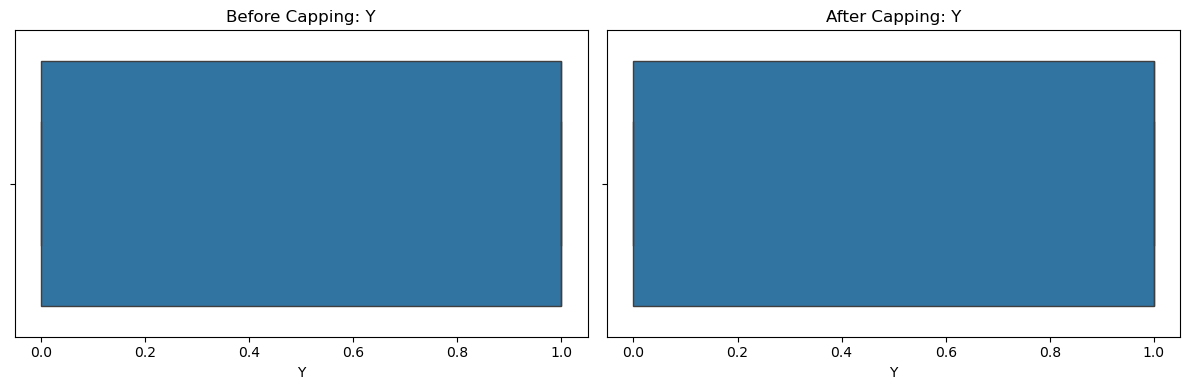

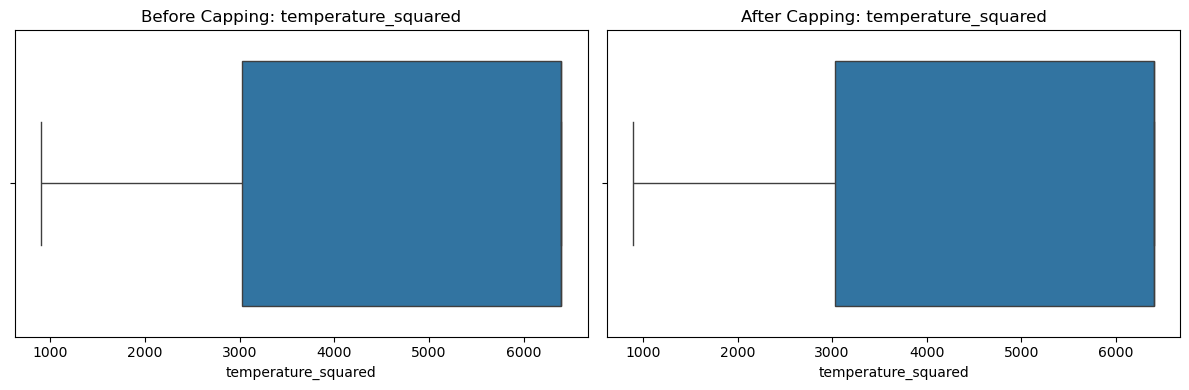

In [52]:
                              #Apply Cap Outliers
# Apply IQR-based capping to numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper) 

print(f"Applied capping to column: {col}")

print("\nAfter capping:\n", df)

# Visualize Boxplots (Before vs After)
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Before Capping
    sns.boxplot(x=df_before_capping[col], ax=axes[0])
    axes[0].set_title(f"Before Capping: {col}")
    
    # After Capping
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"After Capping: {col}")

    plt.tight_layout()
    plt.show()

## Encoding And Feature Selection

In [54]:
#One-hot encode all categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Confirm result
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Original shape: (12610, 26)
Encoded shape: (12610, 94)


,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,temperature_squared,destination_No Urgent Place,...,CarryAway_less1,CarryAway_never,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,1286.889479,1,1,0,0.0,0,1,1,3025,True,...,False,True,True,False,False,False,False,False,False,False
1,2676.682139,1,1,0,0.0,0,1,0,6400,True,...,False,True,True,False,False,False,False,False,False,False
2,2676.682139,1,1,1,0.0,0,1,1,6400,True,...,False,True,True,False,False,False,False,False,False,False
3,2676.682139,1,1,1,0.0,0,1,0,6400,True,...,False,True,True,False,False,False,False,False,False,False
4,2676.682139,1,1,1,0.0,0,1,0,6400,True,...,False,True,True,False,False,False,False,False,False,False


In [55]:
#Rechecking if encoding happened:
df_encoded.dtypes


temperature                   float64
has_children                    int64
toCoupon_GEQ5min                int64
toCoupon_GEQ15min               int64
toCoupon_GEQ25min             float64
                               ...   
RestaurantLessThan20_never       bool
Restaurant20To50_4~8             bool
Restaurant20To50_gt8             bool
Restaurant20To50_less1           bool
Restaurant20To50_never           bool
Length: 94, dtype: object

In [56]:
# Drop all object type columns from the encoded DataFrame
df_encoded = df_encoded.drop(columns=df_encoded.select_dtypes(include=['object']).columns)

# Double-check
print(df_encoded.dtypes)

temperature                   float64
has_children                    int64
toCoupon_GEQ5min                int64
toCoupon_GEQ15min               int64
toCoupon_GEQ25min             float64
                               ...   
RestaurantLessThan20_never       bool
Restaurant20To50_4~8             bool
Restaurant20To50_gt8             bool
Restaurant20To50_less1           bool
Restaurant20To50_never           bool
Length: 94, dtype: object


In [57]:
# Create a copy of the original dataset to avoid modifying the original
df_encoded = df.copy()

# Loop through all object and boolean columns and apply label encoding
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object', 'bool']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Now create the numeric-only subset
df_numeric = df_encoded.select_dtypes(include=['number'])

# Make a copy for further use
df1 = df_numeric.copy()

# Display to verify
print(df1.head())

print(df1.shape)

print(df1.dtypes)

   temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
0  1286.889479             1                 1                  0   
1  2676.682139             1                 1                  0   
2  2676.682139             1                 1                  1   
3  2676.682139             1                 1                  1   
4  2676.682139             1                 1                  1   

   toCoupon_GEQ25min  direction_same  direction_opp  Y  temperature_squared  
0                0.0               0              1  1                 3025  
1                0.0               0              1  0                 6400  
2                0.0               0              1  1                 6400  
3                0.0               0              1  0                 6400  
4                0.0               0              1  0                 6400  
(12610, 9)
temperature            float64
has_children             int64
toCoupon_GEQ5min         int64
toCoupon_GEQ1

In [58]:
df1

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,temperature_squared
0,1286.889479,1,1,0,0.0,0,1,1,3025
1,2676.682139,1,1,0,0.0,0,1,0,6400
2,2676.682139,1,1,1,0.0,0,1,1,6400
3,2676.682139,1,1,1,0.0,0,1,0,6400
4,2676.682139,1,1,1,0.0,0,1,0,6400
...,...,...,...,...,...,...,...,...,...
12605,1286.889479,0,1,0,0.0,0,1,1,3025
12606,1286.889479,0,1,0,0.0,0,1,1,3025
12607,393.351422,0,1,0,0.0,0,1,0,900
12608,393.351422,0,1,1,0.0,0,1,0,900


In [59]:
df1.columns

Index(['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'temperature_squared'],
      dtype='object')

In [60]:
# Drop target column before scaling:
X=df_encoded.drop('Y',axis=1)
y=df_encoded['Y']


In [61]:
              #FEATURE SCALING

# Initialize scaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

df1 = df_scaled.copy()

# Display first rows
print(df1.head())
print(df1.shape)


   temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
0    -0.602255      1.188475               0.0          -1.127680   
1     0.918747      1.188475               0.0          -1.127680   
2     0.918747      1.188475               0.0           0.886776   
3     0.918747      1.188475               0.0           0.886776   
4     0.918747      1.188475               0.0           0.886776   

   toCoupon_GEQ25min  direction_same  direction_opp         Y  \
0                0.0             0.0            0.0  0.872875   
1                0.0             0.0            0.0 -1.145639   
2                0.0             0.0            0.0  0.872875   
3                0.0             0.0            0.0 -1.145639   
4                0.0             0.0            0.0 -1.145639   

   temperature_squared  
0            -0.609505  
1             0.920414  
2             0.920414  
3             0.920414  
4             0.920414  
(12610, 9)


In [62]:
# TO VERIFY

# Check the scaled result
df_scaled[numeric_cols].describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,temperature_squared
count,1.261000e+04,1.261000e+04,12610.0,1.261000e+04,12610.0,12610.0,12610.0,1.261000e+04,1.261000e+04
mean,2.704683e-16,-1.712966e-16,0.0,-4.958585e-17,0.0,0.0,0.0,4.057024e-17,-2.524371e-16
std,1.000040e+00,1.000040e+00,0.0,1.000040e+00,0.0,0.0,0.0,1.000040e+00,1.000040e+00
min,-1.580151e+00,-8.414142e-01,0.0,-1.127680e+00,0.0,0.0,0.0,-1.145639e+00,-1.572788e+00
25%,-6.022549e-01,-8.414142e-01,0.0,-1.127680e+00,0.0,0.0,0.0,-1.145639e+00,-6.095054e-01
50%,9.187465e-01,-8.414142e-01,0.0,8.867762e-01,0.0,0.0,0.0,8.728754e-01,9.204142e-01
75%,9.187465e-01,1.188475e+00,0.0,8.867762e-01,0.0,0.0,0.0,8.728754e-01,9.204142e-01
max,9.187465e-01,1.188475e+00,0.0,8.867762e-01,0.0,0.0,0.0,8.728754e-01,9.204142e-01


In [63]:
# Check scaling result
print("Column-wise mean after scaling:")
print(df1.mean())

print("\nColumn-wise standard deviation after scaling:")
print(df1.std())

Column-wise mean after scaling:
temperature            2.704683e-16
has_children          -1.712966e-16
toCoupon_GEQ5min       0.000000e+00
toCoupon_GEQ15min     -4.958585e-17
toCoupon_GEQ25min      0.000000e+00
direction_same         0.000000e+00
direction_opp          0.000000e+00
Y                      4.057024e-17
temperature_squared   -2.524371e-16
dtype: float64

Column-wise standard deviation after scaling:
temperature            1.00004
has_children           1.00004
toCoupon_GEQ5min       0.00000
toCoupon_GEQ15min      1.00004
toCoupon_GEQ25min      0.00000
direction_same         0.00000
direction_opp          0.00000
Y                      1.00004
temperature_squared    1.00004
dtype: float64


## creating pipeline

In [65]:
# Drop target column before scaling:
X=df_encoded.drop('Y',axis=1)
y=df_encoded['Y']

# Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])
# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (10088, 25) (10088,)
Test shape: (2522, 25) (2522,)


## Model Training And Evaluation

Accuracy on Test Set: 0.6708961141950832

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.55      0.60      1106
           1       0.69      0.76      0.72      1416

    accuracy                           0.67      2522
   macro avg       0.67      0.66      0.66      2522
weighted avg       0.67      0.67      0.67      2522

Accuracy: 0.6709
ROC-AUC: 0.7250


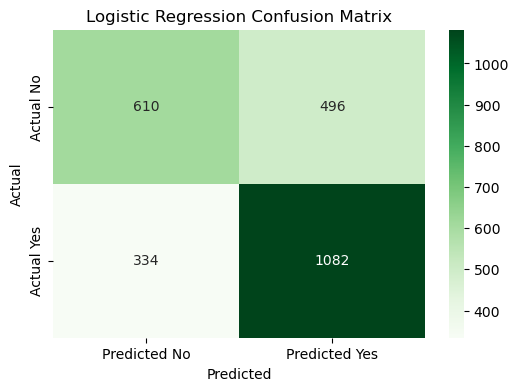

In [67]:
# Logistic Regression

# Define pipeline with LogisticRegression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the pipeline on training data
lr_pipeline.fit(X_train, y_train)

# Make predictions on test data
y_pred = lr_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Predictions
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:, 1]  
# Accuracy & ROC-AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


Accuracy on Test Set: 0.7442505947660587

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      1106
           1       0.75      0.82      0.78      1416

    accuracy                           0.74      2522
   macro avg       0.74      0.73      0.74      2522
weighted avg       0.74      0.74      0.74      2522

Random Forest Results
Accuracy: 0.7443
ROC-AUC: 0.8152


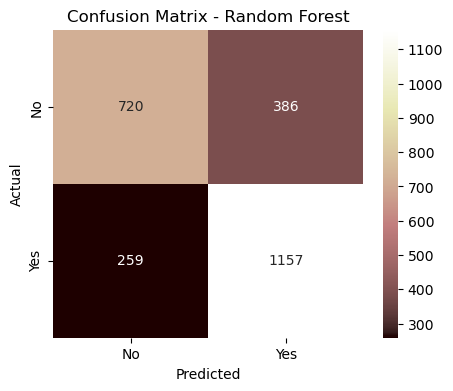

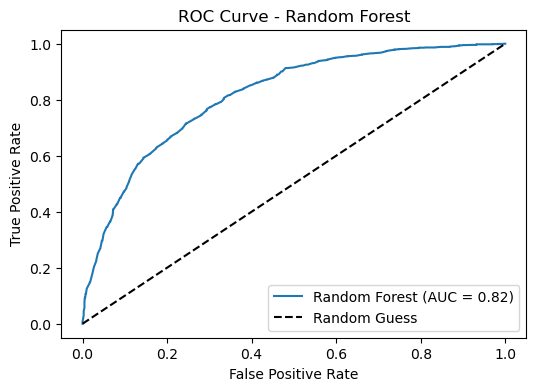

In [68]:
# Random Forest

# Define the full pipeline with RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = rf_pipeline.predict(X_test)

# Evaluate
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Predictions
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Accuracy and ROC-AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Random Forest Results")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


Accuracy on test set: 0.7291831879460745

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.67      1106
           1       0.73      0.81      0.77      1416

    accuracy                           0.73      2522
   macro avg       0.73      0.72      0.72      2522
weighted avg       0.73      0.73      0.73      2522

SVC Results
Accuracy: 0.7292
ROC-AUC: 0.8006


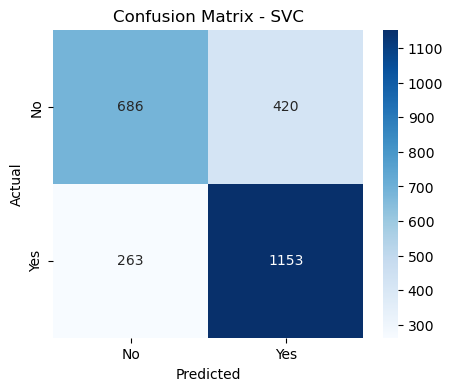

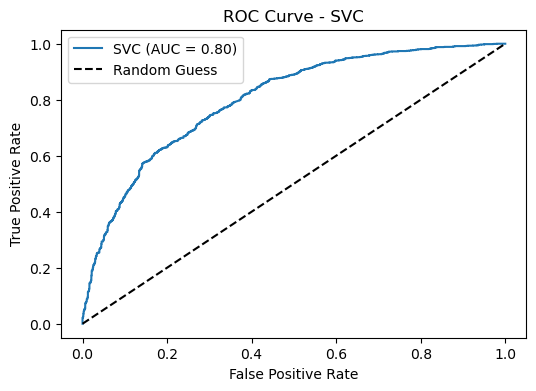

In [69]:
#svc

# Full pipeline with SVC classifier
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale',probability=True))
    
])
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
clf_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = clf_pipeline.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Predictions
y_pred = clf_pipeline.predict(X_test)
y_proba =clf_pipeline.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Accuracy and ROC-AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("SVC Results")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'SVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.show()

Accuracy on test set: 0.661776367961935

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59      1106
           1       0.68      0.75      0.71      1416

    accuracy                           0.66      2522
   macro avg       0.66      0.65      0.65      2522
weighted avg       0.66      0.66      0.66      2522

KNN Classifier Results
Accuracy: 0.6618
ROC-AUC: 0.7063


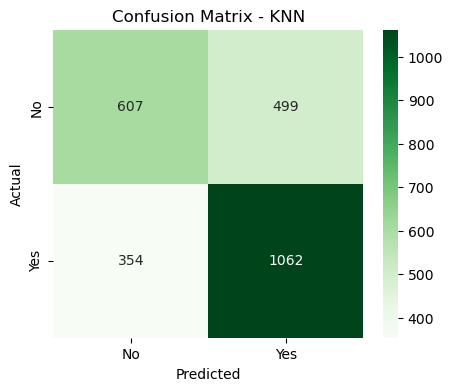

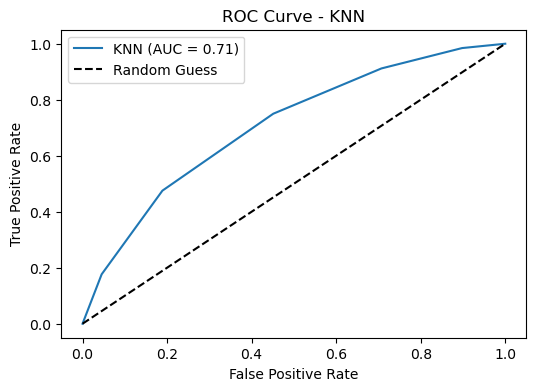

In [70]:
# knn

# Define the pipeline with KNN classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Default is 5, can be tuned
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = knn_pipeline.predict(X_test)

# Evaluate performance
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 #Predictions
y_pred = knn_pipeline.predict(X_test)
y_proba = knn_pipeline.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Accuracy and ROC-AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("KNN Classifier Results")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()


Accuracy on test set: 0.703806502775575

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63      1106
           1       0.71      0.80      0.75      1416

    accuracy                           0.70      2522
   macro avg       0.70      0.69      0.69      2522
weighted avg       0.70      0.70      0.70      2522

Gradient Boosting Results
Accuracy: 0.7038
ROC-AUC: 0.7696


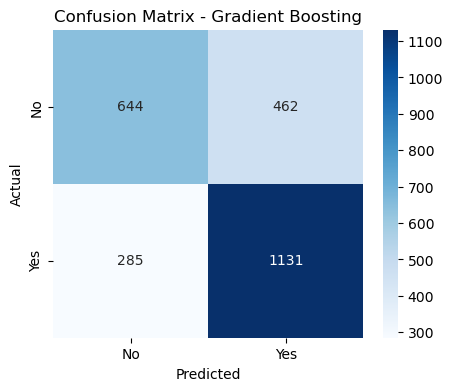

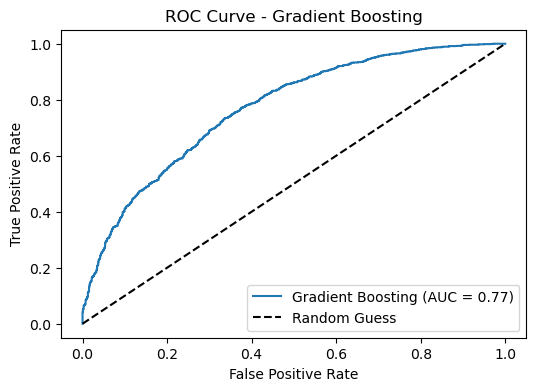

In [71]:
# Gradient Boosting Classifier

# Define the pipeline with Gradient Boosting classifier
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,        # Number of boosting stages (can be tuned)
        learning_rate=0.1,       # Step size shrinkage (can be tuned)
        max_depth=3,             # Depth of individual estimators (can be tuned)
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the pipeline
gb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = gb_pipeline.predict(X_test)

# Evaluate performance
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Predictions
y_pred = gb_pipeline.predict(X_test)
y_proba = gb_pipeline.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Accuracy and ROC-AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Gradient Boosting Results")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.show()

Accuracy on test set: 0.6736716891356067

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.62      1106
           1       0.71      0.72      0.71      1416

    accuracy                           0.67      2522
   macro avg       0.67      0.67      0.67      2522
weighted avg       0.67      0.67      0.67      2522

ROC-AUC Score: 0.6673249915713979


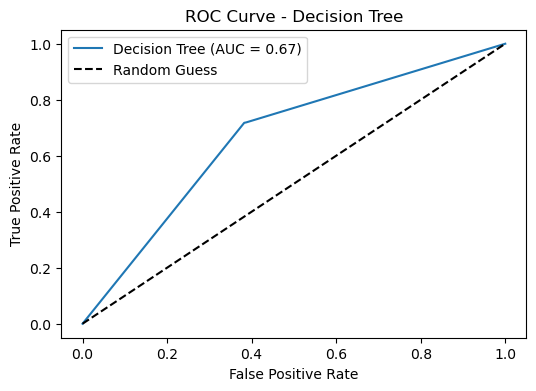

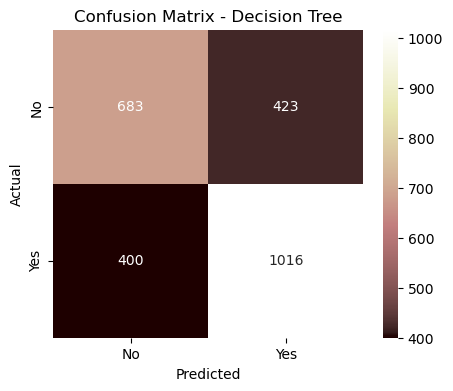

In [72]:
# Define the pipeline with Decision Tree classifier
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',       # 'gini' or 'entropy'
        max_depth=None,         # None means nodes are expanded until all leaves are pure
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the pipeline
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_pipeline.predict(X_test)

# Evaluate performance
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Predict probabilities for ROC-AUC
y_proba = dt_pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

In [73]:
results = [
    {"Model": "Logistic Regression", "Accuracy": 0.67, "ROC-AUC": 0.72, "F1 Score": 0.72},
    {"Model": "Decision Tree", "Accuracy": 0.67, "ROC-AUC": 0.66, "F1 Score": 0.71},
    {"Model": "Random Forest", "Accuracy": 0.74, "ROC-AUC": 0.81, "F1 Score": 0.78},
    {"Model": "Gradient Boosting", "Accuracy": 0.70, "ROC-AUC": 0.76, "F1 Score": 0.75},
    {"Model": "KNN", "Accuracy": 0.66, "ROC-AUC": 0.70, "F1 Score": 0.75},
    {"Model": "SVC", "Accuracy": 0.72, "ROC-AUC": 0.80, "F1 Score": 0.77}
]

# Create DataFrame
results_df = pd.DataFrame(results)

# Sort by ROC-AUC or Accuracy if desired
results_df = results_df.sort_values(by="ROC-AUC", ascending=False)

# Display table
print(results_df)

# Optional: Pretty table
try:
    from tabulate import tabulate
    print(tabulate(results_df, headers='keys', tablefmt='psql'))
except:
    pass

# Select the best model (based on ROC-AUC)
best_model = results_df.iloc[0]

print(f"\nThe Best Model Is: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.2f}")
print(f"ROC-AUC: {best_model['ROC-AUC']:.2f}")
print(f"F1 Score: {best_model['F1 Score']:.2f}")

                 Model  Accuracy  ROC-AUC  F1 Score
2        Random Forest      0.74     0.81      0.78
5                  SVC      0.72     0.80      0.77
3    Gradient Boosting      0.70     0.76      0.75
0  Logistic Regression      0.67     0.72      0.72
4                  KNN      0.66     0.70      0.75
1        Decision Tree      0.67     0.66      0.71
+----+---------------------+------------+-----------+------------+
|    | Model               |   Accuracy |   ROC-AUC |   F1 Score |
|----+---------------------+------------+-----------+------------|
|  2 | Random Forest       |       0.74 |      0.81 |       0.78 |
|  5 | SVC                 |       0.72 |      0.8  |       0.77 |
|  3 | Gradient Boosting   |       0.7  |      0.76 |       0.75 |
|  0 | Logistic Regression |       0.67 |      0.72 |       0.72 |
|  4 | KNN                 |       0.66 |      0.7  |       0.75 |
|  1 | Decision Tree       |       0.67 |      0.66 |       0.71 |
+----+---------------------+-----

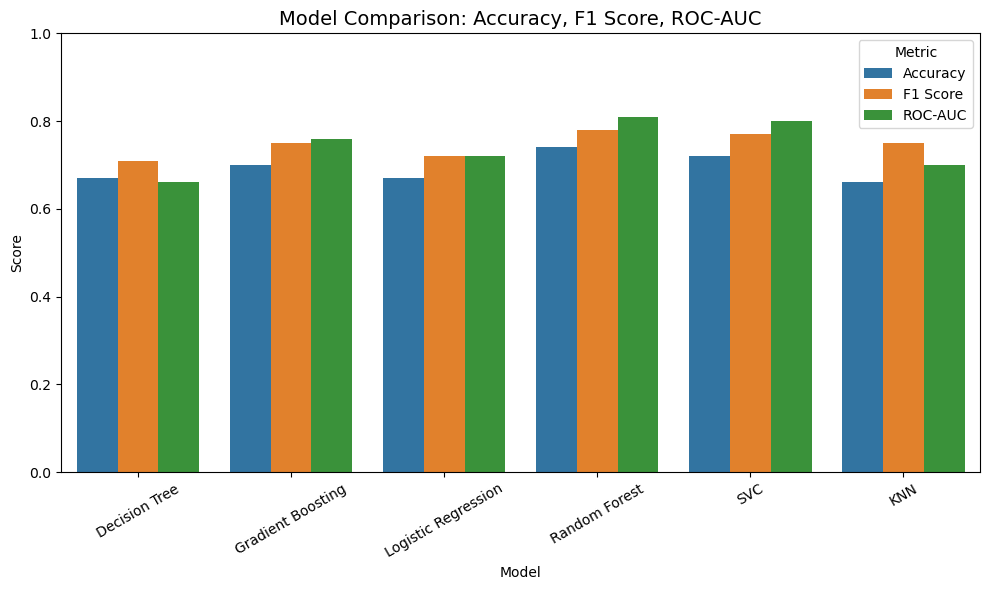

In [74]:
#  results 
model_results = {
    "Model": ["Decision Tree", "Gradient Boosting", "Logistic Regression",
              "Random Forest", "SVC", "KNN"],
    "Accuracy": [0.67, 0.70, 0.67, 0.74, 0.72, 0.66],
    "F1 Score": [0.71, 0.75, 0.72, 0.78, 0.77, 0.75],
    "ROC-AUC": [0.66, 0.76, 0.72, 0.81, 0.80, 0.70]
}

# Create DataFrame
df_results = pd.DataFrame(model_results)

# Convert to long format for Seaborn
df_melt = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="Model", y="Score", hue="Metric")
plt.ylim(0, 1)  # Because scores are between 0 and 1
plt.title("Model Comparison: Accuracy, F1 Score, ROC-AUC", fontsize=14)
plt.xticks(rotation=30)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [75]:

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

# Train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append((name, acc, f1, roc_auc))



In [76]:
# Find the best model by ROC-AUC
best_model = max(results, key=lambda x: x[3])

# Print results
for name, acc, f1, roc_auc in results:
    print(f"{name} -> Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\nThe Best Model Is:", best_model[0])
print(f"Accuracy: {best_model[1]:.4f}, F1: {best_model[2]:.4f}, ROC-AUC: {best_model[3]:.4f}")


Decision Tree -> Accuracy: 0.6737, F1: 0.7117, ROC-AUC: 0.6673
Gradient Boosting -> Accuracy: 0.7038, F1: 0.7517, ROC-AUC: 0.7696
Logistic Regression -> Accuracy: 0.6709, F1: 0.7228, ROC-AUC: 0.7250
Random Forest -> Accuracy: 0.7443, F1: 0.7820, ROC-AUC: 0.8152
SVC -> Accuracy: 0.7292, F1: 0.7715, ROC-AUC: 0.8006
KNN -> Accuracy: 0.6618, F1: 0.7135, ROC-AUC: 0.7063

The Best Model Is: Random Forest
Accuracy: 0.7443, F1: 0.7820, ROC-AUC: 0.8152
